# CS446/546 - Class Session 6 - Degree Distribution

In this class session we are going to plot the degree distribution of the undirected human
protein-protein interaction network (PPI), without using `igraph`. We'll obtain the interaction data from the Pathway Commons SIF file (in the `shared/` folder) and we'll 
manually compute the degree of each vertex (protein) in the network. We'll then compute
the count `N(k)` of vertices that have a given vertex degree `k`, for all `k` values.
Finally, we'll plot the degree distribution and discuss whether it is consistent with the 
results obtained in the Jeong et al. article for the yeast PPI.

We're going to use `ggplot2` in this notebook

In [53]:
library(ggplot2)

Step 1:  load in the SIF file as the data frame `sif_data` (with column names `species1`, `interaction_type`, and `species2`), using the function `read.table`

Let's take a look at the top of the data frame, using the `head` function:

In [69]:
head(sif_data)

species1,interaction_type,species2
A1BG,controls-expression-of,A2M
A1BG,interacts-with,ABCC6
A1BG,interacts-with,ACE2
A1BG,interacts-with,ADAM10
A1BG,interacts-with,ADAM17
A1BG,interacts-with,ADAM9


Step 2:  restrict the interactions to undirected protein-protein interactions. We will do this by subsetting the data frame to only rows for which the `interaction_type` column contains either `in-complex-with` or `interacts-with`. We'll also subset the data frame to include only the `species1` and `species2` columns.  There are two ways to do it, (i) using standard indexing and (ii) using the `subset` function.

Here is how you would do it using standard indexing:

In [55]:
interac_ppi <- sif_data[sif_data$interaction_type %in% c("in-complex-with",
                                                         "interacts-with"), c(1,3)]

Now you can try it using the `subset` function; this code is arguably more "readable":

Use the `head` function to show the first few rows of the data frame, and use the `nrow` function to see how many rows it is:

,species1,species2
2,A1BG,ABCC6
3,A1BG,ACE2
4,A1BG,ADAM10
5,A1BG,ADAM17
6,A1BG,ADAM9
7,A1BG,AGO1


[1] 508480

Step 3: for each interaction, reorder `species1` and `species2` (if necessary) so that
`species1 < species2` (in terms of lexicographic order); we are doing this because there are many cases where a pair of proteins "X" and "Y" appear in the database as both [X,Y] and [Y,X], and we want those edges to be recognized as the same so that they are not separately counted. We'll do this using `subset` twice (once for `species1 < species2` and once for `species1 >= species2`) and then stacking the two data frames that were returned from the two calls to `subset`, using the `rbind` function.  Save it as a data frame `interac_ppi_ordered`.

The number of rows in `interac_ppi_ordered` should be the same as for `interac_ppi`; let's verify that.

In [71]:
nrow(interac_ppi_ordered)

[1] 508480

Step 4: get only the unique interaction pairs of proteins (ignoring the interaction type), using the `unique` function; save as the object `interac_ppi_unique`.

How many rows do we have now? Let's print it out

In [61]:
nrow(interac_ppi_unique)

[1] 475553

Step 5: compute the degree of each vertex.  We'll do this by making a single character vector that is the concatenation of the `species1` and `species2` columns of `interac_ppi_unique`, and then we'll use the `table` function to compute the number of times each protein name occurs (you could also do the same thing by using the `sort` and `rle` functions, but `table` is easier to remember). Save the results as `vertex_degrees`.

Let's have a look at `vertex_degrees`

In [74]:
head(vertex_degrees)


  A1BG   A1CF    A2M  A2ML1 A4GALT  A4GNT 
    59     34    171      4      6     19 

Step 6: Calculate the histogram of N(k) vs. k, "suggesting" 30 bin "breaks" (i.e., bin edges) to R; `hist` will actually pick a different number of bins based on its own histogramming algorithm, so we'll find out exactly how many bin breaks that `hist` picked and then we'll call it `nbreaks_actual`, and we'll work with that. 

In [63]:
nbreaks <- 30
hist_res <- hist(vertex_degrees, plot=FALSE, nclass=nbreaks)
hist_counts <- hist_res$counts
hist_breaks <- hist_res$breaks
nbreaks_actual <- length(hist_breaks)
kvals <- (hist_breaks[1:(nbreaks_actual-1)] + hist_breaks[-1])/2

Step 7: Plot `N(k)` vs. `k`, on log-log scale.  Restrict the horizontal axis to only values up to (but not including) the first zero value of `N(k)`.

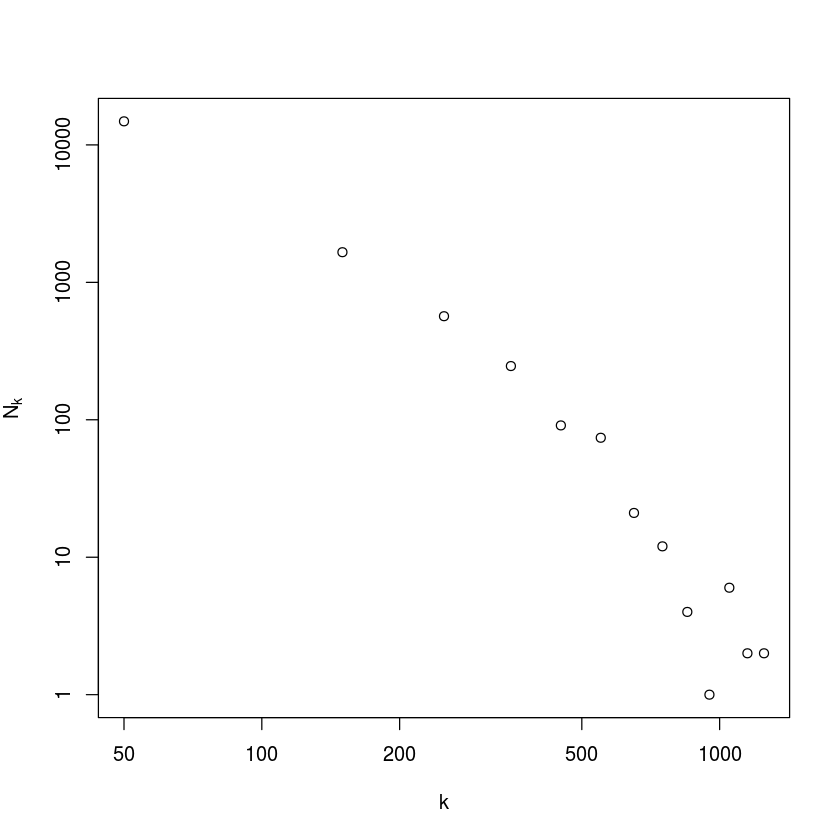

In [64]:
indend <- min(which(hist_counts == 0))
indend <- if (length(indend) == 0) { length(kvals) } else { indend - 1 }
plot(kvals[1:indend],
     hist_counts[1:indend],
     type="p",
     main="",
     log="xy",
     xlab=expression(k),
     ylab=expression(N[k]))

Let's also plot the data using `ggplot2` instead of R base graphics.  We'll use the functions `ggplot`, `geom_point`

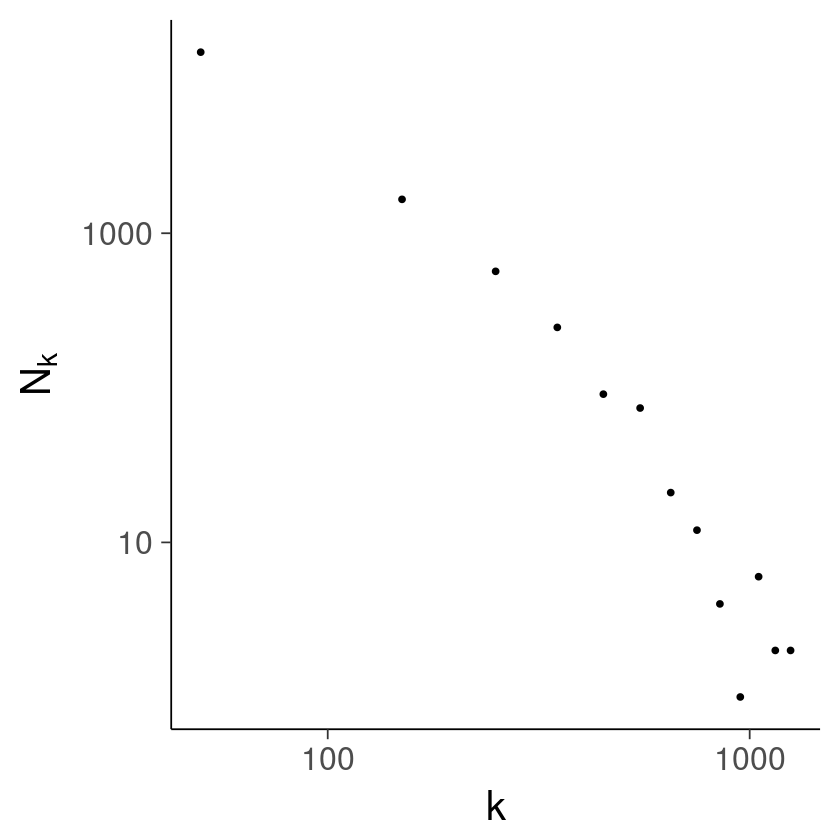

In [75]:
print(ggplot(data=data.frame(k=kvals[1:indend], Nk=hist_counts[1:indend]), aes(x=k, y=Nk)) + 
      geom_point() + 
      theme_classic(base_size=24) +
      scale_x_log10() +
      scale_y_log10() +
      ylab(expression(N[k])))

Step 8:  Do a linear fit to the log10(N(k)) vs. log10(k) data.  Restrict your analysis to the k bin values for which the log(Nk) vs. log(k) relationship is linear-looking, which is the first four points on the plot.  You'll use `lm` to fit the linear model (make sure to log10 transform the data using the `log10` function), and `summary` to print the results from the linear model.  

In [76]:
# put the data from the linear range, into a data frame 
degdist_df <- data.frame(log10Nk=log10(hist_counts[1:4]),
                         log10k=log10(kvals[1:4]))

# linear regression
summary(lm(log10Nk ~ log10k, 
           data=degdist_df))


Call:
lm(formula = log10Nk ~ log10k, data = degdist_df)

Residuals:
       1        2        3        4 
-0.01571  0.02675  0.02349 -0.03453 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.72896    0.12811   60.33 0.000275 ***
log10k      -2.08465    0.05752  -36.24 0.000760 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03679 on 2 degrees of freedom
Multiple R-squared:  0.9985,	Adjusted R-squared:  0.9977 
F-statistic:  1314 on 1 and 2 DF,  p-value: 0.0007604


What is the slope?  Can you find it in the `summary` output?  (Hint:  it's under the "Coefficients" part).

Now let's compute the slope for the degree distribution Fig. 1b in the Jeong et al. article, for the yeast PPI.  The change in ordinate over the linear range is about -6.5 in units of natural logarithm. The change in abscissa over the linear range is approximately log(45)-log(2), so we can compute the Jeong et al. slope thus:

In [1]:
round(-6.5/(log(45)-log(2)), digits=2)

How close is the human PPI slope to the Jeong. et al. slope?